# Where to open a Spanish restaurant in Madrid
PROJECT NOTEBOOK  

### Table of Contents
> [Setup](#setup)  
  [Collect the data](#collect-data)  
  [Understand and prepare the data](#understand-prepare-data)  
  [Normalize the model features](#normalize-features)  
  [Cluster the neighborhoods](#cluster-nbhs)  
  [Describe the clusters](#describe-clusters)  
  [Select the most suitable cluster](#select-cluster)  
  [Discard causes for neighborhood unsuitability](#discard-unsuitability)  
  [Explore the selected cluster for stand-out neighborhoods](#find-nbhs)  
  [RECOMMENDATION](#recommendation)

<a class="anchor" id="setup"></a>
## Setup

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

import folium

import json
from pandas.io.json import json_normalize

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

<a class="anchor" id="collect-data"></a>
## Collect the data
>
- Scrape the following Wikipedia page, https://es.wikipedia.org/wiki/Anexo:Barrios_administrativos_de_Madrid, in order to obtain the data that is in the table of Madrid districts and neighborhoods—including the links to the Wikipedia page of each neighborhood, and transform the data into a pandas dataframe
- Scrape the latitude and longitude of each neighborhood from the corresponding Wikipedia page, and add them to the neighborhood dataframe
- Get the second hand housing price for each neighborhood from [here](https://www.madrid.es/UnidadesDescentralizadas/UDCEstadistica/Nuevaweb/Edificaci%C3%B3n%20y%20Vivienda/Mercado%20de%20la%20Vivienda/Precios%20de%20la%20Vivienda/Distritos/E3320219.xls)
- Get the top venues for each neighborhood from FourSquare

### Scrape Madrid districts and neighborhoods

Fetch the Wikipedia page with Madrid districts and neighborhoods:

In [2]:
nbhsUrl = 'https://es.wikipedia.org/wiki/Anexo:Barrios_administrativos_de_Madrid'
nbhsHtml = requests.get(nbhsUrl).text

Pass the HTML to BeautifulSoup() and extract the table with the districts and neighborhoods:

In [3]:
nbhsSoup = BeautifulSoup(nbhsHtml, 'html5lib')
nbhsTable = nbhsSoup('table', {'class': "wikitable sortable"})[0]
print('HTML neighborhood table has {} columns and {} rows'.format(
    len(nbhsTable('th')),
    len(nbhsTable('tr'))))

HTML neighborhood table has 5 columns and 132 rows


Extract neighborhood table rows as a nested list

In [4]:
# Get neighborhoods handling html table inconsistencies and first empty row
nbhRows = [(([''] if len(tr('td')) == 4 else []) +
            [str.strip(td.text) for td in tr('td')] +
            [tr('a')[len(tr('a'))-2]['href']]) for tr in nbhsTable('tr')[1:]]   

# Fill empty boroughs
for row, nbh in enumerate(nbhRows):
    if nbh[0] == '':
        nbh[0] = nbhRows[row-1][0]

# Print number of neighborhoods
print('Number of neighborhoods:', len(nbhRows))

Number of neighborhoods: 131


Create neighborhood dataframe, and print number of neighborhoods and first 8 neighborhoods:

In [5]:
nbhColumns = ['District', 'Number', 'Neighborhood', 'Area', 'Image', 'Link']
nbhDf = pd.DataFrame(nbhRows, columns=nbhColumns)
nbhDf.drop(columns='Image', inplace=True)                                                                   # drop empty image column
nbhDf['Area'] = nbhDf['Area'].apply(lambda s: s.replace('km²', '').strip().replace(',','.'))                # clean Area
nbhDf['Area'] = pd.to_numeric(nbhDf['Area'], errors='coerce')
print('Number of neighborhoods:', nbhDf.shape[0])
print('First 7 nighborhoods:')
nbhDf.head(7)

Number of neighborhoods: 131
First 7 nighborhoods:


,District,Number,Neighborhood,Area,Link
0,Centro,11,Palacio,1.471,/wiki/Palacio_(Madrid)
1,Centro,12,Embajadores,1.032,/wiki/Embajadores_(Madrid)
2,Centro,13,Cortes,0.592,/wiki/Cortes_(Madrid)
3,Centro,14,Justicia,0.742,/wiki/Justicia_(Madrid)
4,Centro,15,Universidad,0.947,/wiki/Universidad_(Madrid)
5,Centro,16,Sol,0.445,/wiki/Sol_(Madrid)
6,Arganzuela,21,Imperial,0.967,/wiki/Imperial_(Madrid)


Check for null values:

In [6]:
nbhDf.isna().sum()

District        0
Number          0
Neighborhood    0
Area            3
Link            0
dtype: int64

Fill null Area values with mean neighborhood area and re-check for null values:

In [7]:
nbhDf['Area'].fillna(nbhDf['Area'].mean(), inplace=True)
nbhDf.isnull().sum()

District        0
Number          0
Neighborhood    0
Area            0
Link            0
dtype: int64

Add empty columns Latitude and Longitude to postal code dataframe:

In [8]:
nbhColumns = nbhDf.columns.tolist() + ['Latitude', 'Longitude']
nbhDf = nbhDf.reindex(columns=nbhColumns)
nbhDf.head(1)

,District,Number,Neighborhood,Area,Link,Latitude,Longitude
0,Centro,11,Palacio,1.471,/wiki/Palacio_(Madrid),NaN,NaN


### Scrape latitude and longitude from neighborhood Wikipedia pages

Create a function to transform coordinates from DDD°MM′SS″+Compass to signed degree format:

In [9]:
def coordDegToDec(coordDeg):
    d,m,s = (coordDeg[:-1].split('°')[0],
             coordDeg[:-1].split('°')[1].split("′")[0],
             coordDeg[:-1].split('°')[1].split("′")[1].split("″")[0] or '0.')
    sign = 1 if ('N' in coordDeg or 'E' in coordDeg) else -1
    return sign * (float(d) + float(m)/60 + float(s)/3600)

Loop through neighborhood pages to scrape their latitudes and longitudes, update the neighborhood dataframe, and print the updated first 5 rows: 

In [10]:
baseUrl = 'https://es.wikipedia.org'

for index, row in nbhDf.iterrows():
    nbhUrl = baseUrl + row['Link'] 
    nbhHtml = requests.get(nbhUrl).text
    nbhSoup = BeautifulSoup(nbhHtml, 'html5lib')
    nbhLat = nbhSoup('span', {'class': 'geo-dms'})[0]('span', {'class': 'latitude'})[0].text.strip()
    nbhLng = nbhSoup('span', {'class': 'geo-dms'})[0]('span', {'class': 'longitude'})[0].text.strip()
    nbhDf.loc[index, 'Latitude'] = coordDegToDec(nbhLat)
    nbhDf.loc[index, 'Longitude'] = coordDegToDec(nbhLng)
nbhDf.head()

,District,Number,Neighborhood,Area,Link,Latitude,Longitude
0,Centro,11,Palacio,1.471,/wiki/Palacio_(Madrid),40.415000,-3.713333
1,Centro,12,Embajadores,1.032,/wiki/Embajadores_(Madrid),40.408889,-3.699722
2,Centro,13,Cortes,0.592,/wiki/Cortes_(Madrid),40.414167,-3.698056
3,Centro,14,Justicia,0.742,/wiki/Justicia_(Madrid),40.423889,-3.696389
4,Centro,15,Universidad,0.947,/wiki/Universidad_(Madrid),40.425278,-3.708333


Check for null values:

In [11]:
nbhDf[['Latitude', 'Longitude']].isnull().sum()

Latitude     0
Longitude    0
dtype: int64

### Get the second hand housing price for each neighborhood
> The .XLS file imported below has been downloaded from [here](https://www.madrid.es/portales/munimadrid/es/Inicio/El-Ayuntamiento/Estadistica/Areas-de-informacion-estadistica/Edificacion-y-vivienda/Mercado-de-la-vivienda/Precios-de-la-vivienda/?vgnextfmt=default&vgnextoid=bf281b47a277b210VgnVCM1000000b205a0aRCRD&vgnextchannel=22613c7ea422a210VgnVCM1000000b205a0aRCRD). A pivot table with neighborhood number and price average per neighborhood has been created for simplicity.

Load 2nd hand prices housing prices per neighborhood to a series and print first 5 rows:

In [13]:
secondHandPricePs = pd.read_excel('madrid-2nd-hand.xls',
                                  sheet_name='capstonePivotTable',
                                  index_col = 'Borough Number')
secondHandPricePs.columns = ['Price 2nd Hand Housing']
secondHandPricePs.index.name = 'Number'
secondHandPricePs.index = secondHandPricePs.index.astype(str)
secondHandPricePs.head()

,Price 2nd Hand Housing
Number,
11,4873.0
12,4239.0
13,5106.0
14,5989.0
15,5068.0


In [14]:
nbhDf = nbhDf.join(secondHandPricePs, on='Number')
nbhDf.head()

,District,Number,Neighborhood,Area,Link,Latitude,Longitude,Price 2nd Hand Housing
0,Centro,11,Palacio,1.471,/wiki/Palacio_(Madrid),40.415000,-3.713333,4873.0
1,Centro,12,Embajadores,1.032,/wiki/Embajadores_(Madrid),40.408889,-3.699722,4239.0
2,Centro,13,Cortes,0.592,/wiki/Cortes_(Madrid),40.414167,-3.698056,5106.0
3,Centro,14,Justicia,0.742,/wiki/Justicia_(Madrid),40.423889,-3.696389,5989.0
4,Centro,15,Universidad,0.947,/wiki/Universidad_(Madrid),40.425278,-3.708333,5068.0


Check for null values in prices:

In [15]:
nbhDf['Price 2nd Hand Housing'].isna().sum()

0

Save as .CSV:

In [16]:
nbhDf.to_csv('madrid-neighborhoods.csv', index=False)

### Get the top venues for each neighborhood from FourSquare

Reload neighborhoods from the .CSV file created above:

In [17]:
nbhDf = pd.read_csv('madrid-neighborhoods.csv')

Define FoursQuare API credentials and version:

In [18]:
with open('credentials.json') as f:
    credentials = json.load(f)
    CLIENT_ID = credentials['CLIENT_ID']
    CLIENT_SECRET = credentials['CLIENT_SECRET']
    VERSION = '20180605'

Create a function to get from FourSquare the top venues for a list of locations given their latitudes and longitudes:

In [22]:
def getNearbyVenues(neighborhoods, latitudes, longitudes, radius=500, limit=100):
    venuesList = []
    
    # Loop through locations
    for nbh, lat, lng in zip(neighborhoods, latitudes, longitudes):
        # Define the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit
        )
        
        # Send the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # Check whether there are any results
        if len(results) > 0:
            # At least 1 result, return location and relevant information for each nearby venue
            venuesList.append([(
                nbh, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        else:
            # No results, return just one 'empty' venue
            venuesList.append([(
                nbh, 
                lat, 
                lng, 
                np.nan, 
                np.nan, 
                np.nan,  
                np.nan)])
            
    # Create a dataframe from the locations and nearby venues nested list
    nearbyVenuesDf = pd.DataFrame([item for venueList in venuesList for item in venueList])
    nearbyVenuesDf.columns = ['Neighborhood', 
                              'Neighborhood Latitude', 
                              'Neighborhood Longitude', 
                              'Venue', 
                              'Venue Latitude', 
                              'Venue Longitude', 
                              'Venue Category']
    
    # Return the locations and nearby venues dataframe
    return(nearbyVenuesDf)

Get nearby venues from FourSquare and show first 5 venues:

In [24]:
exploreRadius = 500
exploreLimit = 100

nearbyVenuesDf = getNearbyVenues(
    neighborhoods=nbhDf['Neighborhood'],
    latitudes=nbhDf['Latitude'],
    longitudes=nbhDf['Longitude'],
    radius=exploreRadius,
    limit=exploreLimit
)

nearbyVenuesDf.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Palacio,40.415,-3.713333,Santa Iglesia Catedral de Santa María la Real ...,40.415767,-3.714516,Church
1,Palacio,40.415,-3.713333,Cervecería La Mayor,40.415218,-3.712194,Beer Bar
2,Palacio,40.415,-3.713333,Mercado Jamón Iberico,40.415309,-3.711633,Market
3,Palacio,40.415,-3.713333,Plaza de La Almudena,40.416320,-3.713777,Plaza
4,Palacio,40.415,-3.713333,Taberna Rayuela,40.413179,-3.713496,Tapas Restaurant


Save as .CSV file:

In [26]:
filename = 'madrid-nearby-venues-r' + str(exploreRadius) + '-l' + str(exploreLimit) + '.csv'
nearbyVenuesDf.to_csv(filename, index=False)
print('Nearby venues with explore radius={} and limit={} saved as \'{}\''.format(exploreRadius, exploreLimit, filename))

Nearby venues with explore radius=500 and limit=100 saved as 'madrid-nearby-venues-r500-l100.csv'


<a class="anchor" id="understand-prepare-data"></a>
## Understand and prepare the data

Reload neighborhoods and nearby venues from .CSV file:

In [2]:
nbhDf = pd.read_csv('madrid-neighborhoods.csv')
nearbyVenuesDf = pd.read_csv('madrid-nearby-venues-r500-l100.csv')

Plot a histogram of Second Hand Housing Price to confirm sufficient variation between neighborhoods:

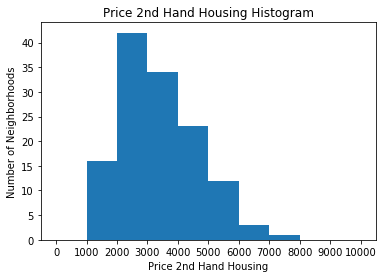

In [3]:
pricePs = nbhDf['Price 2nd Hand Housing']
priceMin = 0
priceMax = 10000
priceBins = 10
priceWidth = 1000
hist = np.histogram(pricePs, np.linspace(priceMin,priceMax,priceBins+1))
plt.bar(hist[1][:-1], hist[0], width=priceWidth, align='edge')
plt.xticks(hist[1])
plt.title('Price 2nd Hand Housing Histogram')
plt.xlabel('Price 2nd Hand Housing')
plt.ylabel('Number of Neighborhoods')
plt.savefig('second-hand-housing-price-hist.jpg')
plt.show()

Visual inspection of the histogram confirms sufficient variability between neighborhoods.

### Feature extraction

#### Neighborhood popularity

Check for empty neighborhoods:

In [4]:
emptyNbhMask = nearbyVenuesDf['Venue'].isna()
emptyNbhs = nearbyVenuesDf[emptyNbhMask]['Neighborhood'].tolist()
print('Empty neighborhoods:', emptyNbhs)

Empty neighborhoods: ['El Cañaveral']


Compute neighborhood 'Popularity' as the total number of popular venues nearby:

In [5]:
nbhPopularityPs = nearbyVenuesDf['Neighborhood'].value_counts()
nbhPopularityPs.name = 'Popularity'
nbhPopularityPs.loc[emptyNbhs] = 0  # set popularity of empty neighborhoods to 0
nbhPopularityPs

Sol                            100
Castellana                     100
Gaztambide                     100
Palacio                        100
Recoletos                      100
                              ... 
El Pardo                         2
Casco Histórico de Vallecas      2
Valdefuentes                     1
El Goloso                        1
El Cañaveral                     0
Name: Popularity, Length: 131, dtype: int64

Plot a histogram to confirm sufficient variability between neighborhoods:

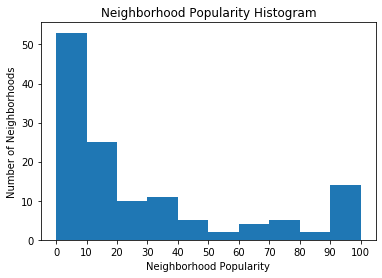

In [6]:
popMin = nbhPopularityPs.min()
popMax = nbhPopularityPs.max()
popBins = 10
popWidth = 10
hist = np.histogram(nbhPopularityPs, np.linspace(popMin,popMax,popBins+1))
plt.bar(hist[1][:-1], hist[0], width=popWidth, align='edge')
plt.xticks(hist[1])
plt.title('Neighborhood Popularity Histogram')
plt.xlabel('Neighborhood Popularity')
plt.ylabel('Number of Neighborhoods')
plt.savefig('neighborhood-popularity-hist.jpg')
plt.show()

Visual inspection of the histogram confirms sufficient variability between neighborhoods.

Create a merged neighborhood dataframe by adding column 'Popularity' to the neighborhood dataframe and check for null values:

In [7]:
mergedNbhDf = nbhDf.join(nbhPopularityPs, on='Neighborhood')
print("Null 'Popularity' values:", mergedNbhDf['Popularity'].isna().sum())

Null 'Popularity' values: 0


Print last 5 rows of the newly created dataframe:

In [8]:
mergedNbhDf.tail()

,District,Number,Neighborhood,Area,Link,Latitude,Longitude,Price 2nd Hand Housing,Popularity
126,Barajas,211,Alameda de Osuna,1.961,/wiki/Alameda_de_Osuna,40.457222,-3.587778,3185.0,24
127,Barajas,212,Aeropuerto,25.132,/wiki/Aeropuerto_(Madrid),40.494167,-3.566944,3242.0,15
128,Barajas,213,Casco Histórico de Barajas,0.609,/wiki/Casco_Hist%C3%B3rico_de_Barajas,40.473611,-3.577222,3242.0,31
129,Barajas,214,Timón,9.595,/wiki/Tim%C3%B3n_(Madrid),40.476667,-3.614167,3242.0,5
130,Barajas,215,Corralejos,4.633,/wiki/Corralejos,40.464444,-3.590000,3242.0,16


#### Direct competition

Compute venue frequency per neighbourhood and print the top venue categories per neighbourhood:

In [9]:
nTopCat = 2

venueFrequencyPs = nearbyVenuesDf.groupby('Neighborhood')['Venue Category'].value_counts(normalize=True)
venueFrequencyPs.name = 'Frequency'
print(venueFrequencyPs.groupby(level='Neighborhood').nlargest(nTopCat).reset_index(level=0, drop=True).round(2).to_string())

Neighborhood                  Venue Category             
Abrantes                      Athletics & Sports             0.12
                              Bakery                         0.12
Acacias                       Spanish Restaurant             0.15
                              Park                           0.08
Adelfas                       Bar                            0.08
                              Fast Food Restaurant           0.08
Aeropuerto                    Airport Lounge                 0.27
                              Coffee Shop                    0.13
Alameda de Osuna              Hotel                          0.08
                              Smoke Shop                     0.08
Almagro                       Restaurant                     0.13
                              Spanish Restaurant             0.13
Almenara                      Flea Market                    0.25
                              Food & Drink Shop              0.25
Almendrales       

Create a list with the venue categories in direct competition with our Spanish restaurant:

In [10]:
directCompetitorCategories = ['Restaurant',
                              'Spanish Restaurant',
                              'Paella Restaurant',
                              'Tapas Restaurant']

Filter the relative frequency of direct competitors for each neighborhood and the first 5 rows ot the series:

In [11]:
directCompetitionPs = venueFrequencyPs[venueFrequencyPs.index.to_frame()['Venue Category'].isin(directCompetitorCategories)]
directCompetitionPs.head()

Neighborhood  Venue Category    
Acacias       Spanish Restaurant    0.145161
              Restaurant            0.048387
              Tapas Restaurant      0.032258
Adelfas       Spanish Restaurant    0.054054
              Tapas Restaurant      0.054054
Name: Frequency, dtype: float64

Compute total direct competition for each neighborhood and print it for 5 neighborhoods:

In [12]:
directCompetitionPs = directCompetitionPs.groupby('Neighborhood').sum()
directCompetitionPs.name = 'Direct Competition'
directCompetitionPs.head()

Neighborhood
Acacias             0.225806
Adelfas             0.108108
Aeropuerto          0.133333
Alameda de Osuna    0.166667
Almagro             0.271429
Name: Direct Competition, dtype: float64

Plot a histogram to confirm sufficient variability between neighborhoods:

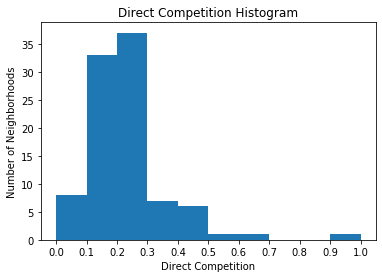

In [13]:
dcMin = 0 # directCompetitionPs.min()
dcMax = 1 # directCompetitionPs.max()
dcBins = 10
dcWidth = 0.1
hist = np.histogram(directCompetitionPs, np.linspace(dcMin,dcMax,dcBins+1))
plt.bar(hist[1][:-1], hist[0], width=dcWidth, align='edge')
plt.xticks(hist[1])
plt.title('Direct Competition Histogram')
plt.xlabel('Direct Competition')
plt.ylabel('Number of Neighborhoods')
plt.savefig('direct-competition-hist.jpg')
plt.show()

Visual inspection of the histogram confirms sufficient variability between neighborhoods.

Add column 'Direct Competition' to the merged neighborhood dataframe and check for null values:

In [14]:
mergedNbhDf = mergedNbhDf.join(directCompetitionPs, on='Neighborhood')
print('Null "Direct Competition" values:', mergedNbhDf['Direct Competition'].isna().sum())

Null "Direct Competition" values: 37


Fill null values with 0 and print first 5 rows of the updated dataframe:

In [15]:
mergedNbhDf['Direct Competition'].fillna(0, inplace=True)
mergedNbhDf.head()

,District,Number,Neighborhood,Area,Link,Latitude,Longitude,Price 2nd Hand Housing,Popularity,Direct Competition
0,Centro,11,Palacio,1.471,/wiki/Palacio_(Madrid),40.415000,-3.713333,4873.0,100,0.33
1,Centro,12,Embajadores,1.032,/wiki/Embajadores_(Madrid),40.408889,-3.699722,4239.0,100,0.14
2,Centro,13,Cortes,0.592,/wiki/Cortes_(Madrid),40.414167,-3.698056,5106.0,100,0.19
3,Centro,14,Justicia,0.742,/wiki/Justicia_(Madrid),40.423889,-3.696389,5989.0,100,0.15
4,Centro,15,Universidad,0.947,/wiki/Universidad_(Madrid),40.425278,-3.708333,5068.0,100,0.09


<a class="anchor" id="normalize-features"></a>
## Normalize the model features

Filter and normalize the features:

In [16]:
featureList = ['Popularity',
               'Price 2nd Hand Housing',
               'Direct Competition']
X = mergedNbhDf[featureList].values

X = MinMaxScaler().fit_transform(X)

X[-5:]

array([[0.24      , 0.28941458, 0.16666667],
       [0.15      , 0.29794879, 0.13333333],
       [0.31      , 0.29794879, 0.25806452],
       [0.05      , 0.29794879, 0.2       ],
       [0.16      , 0.29794879, 0.3125    ]])

<a class="anchor" id="cluster-nbhs"></a>
## Cluster the neighbourhoods

To cluster the neighbourhoods, run KMeans for different values of n_clusters and plot the corresponding model, silhouette scores vs n_clusters to pick the best model:

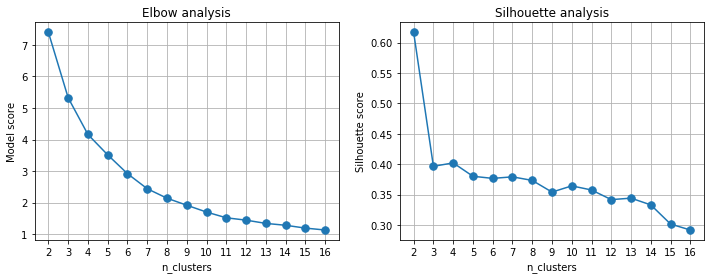

In [17]:
kVal = range(2,17)
randomState = 0
kScores = []
kSilhouetteScores = []

for k in kVal:
    kmeans = KMeans(n_clusters=k, random_state=randomState, n_jobs=-1)
    kmeans.fit(X)
    kScores.append(abs(kmeans.score(X)))
    kSilhouetteScores.append(silhouette_score(X, kmeans.labels_))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
ax1.plot(kVal, kScores, marker='.', markersize=15)
ax1.set(title='Elbow analysis', xlabel='n_clusters', ylabel='Model score', xticks=kVal)
ax1.grid(True)
ax2.plot(kVal, kSilhouetteScores, marker='.', markersize=15)
ax2.set(title='Silhouette analysis', xlabel='n_clusters', ylabel='Silhouette score', xticks=kVal)
ax2.grid(True)
plt.savefig('n_clusters-analysis.jpg')
plt.show()

Both the elbow method for the model score and the sihouette analysis suggest that `n_clusters` = 4 is a good choice.

Define a function to plot a folium map with the clusters for a given `n_clusters` parameter:

In [18]:
def plotClusterMap(n_clusters, clusterList=[]):
    global mergedNbhDf
    global clusterPs
    kBest = n_clusters
    kmeansBest = KMeans(n_clusters=kBest, random_state=randomState, n_jobs=-1)
    kmeansBest.fit(X)
    kmeansBestLabels = kmeansBest.labels_

    # Add 'Cluster' column to merged neighborhoods dataframe 
    if 'Cluster' in mergedNbhDf.columns:
        mergedNbhDf.drop(columns=['Cluster'], inplace=True)
    clusterPs = pd.Series(kmeansBestLabels, index=mergedNbhDf['Neighborhood'], name='Cluster')
    mergedNbhDf = pd.merge(mergedNbhDf, clusterPs, left_on='Neighborhood', right_index=True)

    # Set color scheme for the clusters based on cluster mean popularity
    popArgSort = pd.Series(X[:,0]).groupby(kmeansBestLabels).mean().argsort()
    colorsSort = pd.Series(popArgSort.index.values, index=popArgSort).sort_index().values
    colorsArray = cm.jet(np.linspace(0,1,n_clusters))[colorsSort]
    colorsList = [colors.rgb2hex(i) for i in colorsArray]

    # Initialize folium map
    meanLat = mergedNbhDf['Latitude'].mean()
    meanLng = mergedNbhDf['Longitude'].mean()
    clusterMap = folium.Map(
        location=[meanLat, meanLng],
        zoom_start=12,
        tiles='stamentoner',
    )

    # Plot neighborhoods as circle markers with an area proportional to their popularity and the corresponding cluster color
    emptyNbhRadius = 1
    plotFields = ['Neighborhood', 'Latitude', 'Longitude', 'Popularity', 'Cluster']
    for nbh, lat, lng, pop, cluster in mergedNbhDf[plotFields].values:
        # If no cluster list was provided, plot all clusters. Otherwise plot only clusters in cluster list
        if len(clusterList) == 0 or cluster in clusterList:
            label = nbh + ' [Cluster {}]'.format(cluster)
            folium.CircleMarker(
                [lat, lng],
                radius=np.sqrt(pop) if pop > 0 else emptyNbhRadius,
                popup=folium.Popup(label, parse_html=True),
                fill=True,
                color=colorsList[cluster],
                fill_color=colorsList[cluster],
                fill_opacity=0.7 if pop > 0 else 0,
            ).add_to(clusterMap)

    return clusterMap

Visualize the clusters for `n_clusters` = 4 (Click [here](https://nbviewer.jupyter.org/github/mnlcsty/Coursera_Capstone/blob/master/capstone-notebook.ipynb) if the folium maps don't render on GitHub):

In [19]:
map4 = plotClusterMap(n_clusters=4)
map4.save('map4.html')
map4

All popular neighborhoods (larger markers) are included in one cluster (deep red). This is too coarse for the purposes of this project.

For a finer clustering neither the elbow analysis nor the silhouette scores appear to be useful:
- There are no clear slope changes in the elbow analysis for n_clusters above 4
- Silhouette scores are very close for n_clusters between 4 and 11  

An alternative objective criterion is misclassification risk minimization. The silhouette plot for n_clusters between 4 and 11 (code adapted from [here](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)):

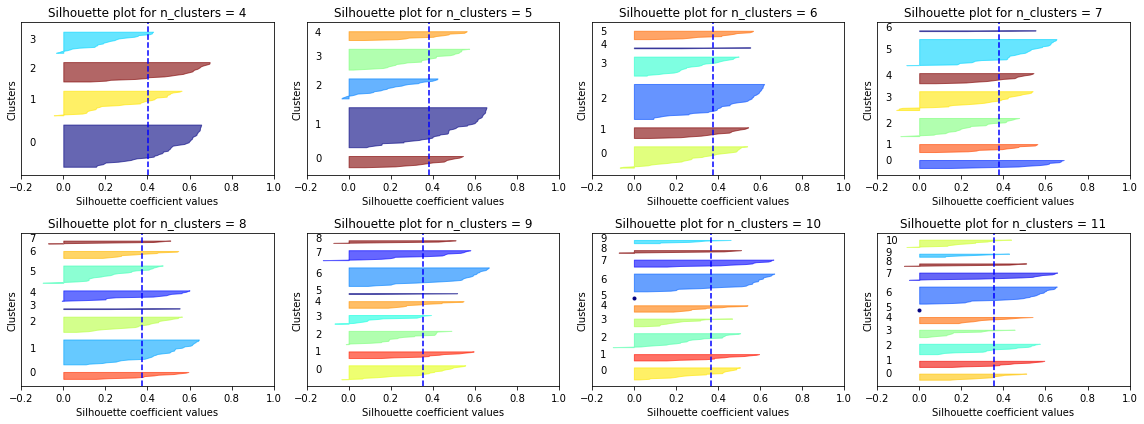

In [20]:
range_n_clusters = range(4, 12)                                                             # Set values of n_clusters to plot the silhouette for
nColPlot = 4                                                                                # Set number of columns for plot
wPlot = 4                                                                                   # Set subplot width
hPlot = 3                                                                                   # Set subplot height
xMin = -0.2                                                                                 # Set subplot lower x-axis limit 
xMax = 1                                                                                    # Set subplot upper x-axis limit
xStep = 0.2                                                                                 # Set subplot distance between x-axis ticks

nRowPlot = len(range_n_clusters) // nColPlot + bool(len(range_n_clusters) % nColPlot)       # Compute number of rows for the plot

fig, axes = plt.subplots(nRowPlot, nColPlot)                                                # Create subplots
fig.set_size_inches(nColPlot*wPlot,nRowPlot*hPlot)                                          # Set figure size
    
for n_clusters, ax in zip(range_n_clusters, axes.flat):                                     # Loop through n_clusters values and subplots
    clusterer = KMeans(n_clusters=n_clusters, random_state=randomState, n_jobs=-1)          # Initialize KMeans
    cluster_labels = clusterer.fit_predict(X)                                               # Cluster the samples
    silhouette_avg = silhouette_score(X, cluster_labels)                                    # Compute average silhouette score 
    sample_silhouette_values = silhouette_samples(X, cluster_labels)                        # Compute the silhouette scores for each sample             
    popArgSort = pd.Series(X[:,0]).groupby(cluster_labels).mean().argsort()                 # Create a sorting array to sort the cluster colors
    colorsSort = pd.Series(popArgSort.index.values, index=popArgSort).sort_index().values   #    in ascending order of mean popularity
    colorsArray = cm.jet(np.linspace(0,1,n_clusters))[colorsSort]                           # Create a colors array and sort it
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])                                        # Insert (n_clusters+1)*10 blank between plots 
    y_lower = 10                                                                            # Set lower y for cluster 0
    for i in range(n_clusters):                                                             # Loop through clusters
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]       # Aggregate the sihouette scores for samples
        ith_cluster_silhouette_values.sort()                                                #   belonging to cluster i and sort them
        size_cluster_i = ith_cluster_silhouette_values.shape[0]                             # Compute silhouette height for cluster i
        y_upper = y_lower + size_cluster_i                                                  # Compute upper y of silhouette for cluster i
        if size_cluster_i == 1:
            ax.plot(ith_cluster_silhouette_values[0], y_lower, '.',                         # Plot a dot if cluster i has only 1 element
                     color=colorsArray[i])
        else:
            ax.fill_betweenx(np.arange(y_lower, y_upper),0,                                 # Plot a silhouette if cluster i has more than 
                             ith_cluster_silhouette_values, alpha=0.6,                      #   1 element
                             facecolor=colorsArray[i], edgecolor=colorsArray[i])
        ax.text(xMin + xStep/5, y_lower + 0.5 * size_cluster_i, str(i))                     # Label dot/silhouette plot with cluster number        
        y_lower = y_upper + 10                                                              # Compute the new y_lower for next plot
    ax.set(title="Silhouette plot for n_clusters = %d" % n_clusters,                        # Set title plot title
           xlabel = "Silhouette coefficient values", ylabel='Clusters',                     # Set plot axis labels
           yticks=[], xticks=np.linspace(xMin, xMax, (xMax-xMin)/xStep+2))                  # Set plot tick marks
    ax.axvline(x=silhouette_avg, color="blue", linestyle="--")                              # Plot vertical line with average silhouette score
fig.tight_layout()                                                                          # Automatic adjust subplots
plt.savefig('silhouette-plots.jpg')
plt.show()                                                                                  # Shop plot

`n_clusters` = 8 appears to be the best option:
- Lowest value of `n_clusters` to split highly popular neighborhoods accross 3 clusters ('short' silhouettes for dark red, red and orange)
- Cleaner plot than 9 and 11 (2 vs 3 clusters with negative coefficient values for some samples)
- Simpler model than 10

Visualize the clusters for `n_clusters` = 8 ((Click [here](https://nbviewer.jupyter.org/github/mnlcsty/Coursera_Capstone/blob/master/capstone-notebook.ipynb) if the folium maps don't render on GitHub):

In [21]:
map8 = plotClusterMap(n_clusters=8)
map8.save('map8.html')
map8

The map confirms that the popular neighborhoods (larger markers) are now split accross three clusters. This is considered to be sufficiently detailed for the purposes of the project

<a class="anchor" id="describe-clusters"></a>
## Describe the clusters

Compute cluster averages:

In [22]:
clusterGrp = mergedNbhDf.groupby('Cluster')[featureList]
clusterGrp.mean().sort_values(by='Popularity', ascending=False).join(clusterGrp.size().to_frame(name='Neighborhoods'))

,Popularity,Price 2nd Hand Housing,Direct Competition,Neighborhoods
Cluster,,,,
7,100.000000,6561.800000,0.246000,5
0,97.272727,4666.454545,0.208530,11
6,67.000000,4791.272727,0.255353,11
2,31.956522,3814.565217,0.190299,23
5,10.038462,2552.384615,0.279071,26
1,8.918919,2172.891892,0.035660,37
4,7.000000,3742.412500,0.025595,16
3,2.500000,3425.333333,0.833333,2


Compute now total feature averages, standard deviations and quartiles:

In [23]:
mergedNbhDf[featureList].describe().T

,count,mean,std,min,25%,50%,75%,max
Popularity,131.0,28.625954,31.776463,0.0,5.0,14.00,38.00,100.0
Price 2nd Hand Housing,131.0,3344.024936,1275.807432,1252.0,2246.5,3234.00,4185.00,7931.0
Direct Competition,131.0,0.163061,0.151136,0.0,0.0,0.16,0.25,1.0


Prepare the **cluster description table** by comparing cluster means with total quartiles, means and standard deviations:

Cluster | #Neighborhoods | Popularity | Price 2nd Hand Housing | Direct Competition 
---: | --- | --- | --- | --- 
7 | 5 | Very high | Very high | Moderate 
0 | 11 | Very high | High | Moderate 
6 | 11 | High | High | High 
2 | 23 | Moderate | Moderate | Moderate 
5 | 26 | Below average | Below average | High 
1 | 37 | Below average | Low | Low 
4 | 16 | Below average | Moderate  | Low 
3 | 2 | Low | Average | Very high 

<a class="anchor" id="select-cluster"></a>
## Select the most suitable cluster
> The restaurant owner's preferences are:
- **Neighborhood popularity**: high popularity is desirable, very high popularity or less than high popularity is not
- **Location-related capital requirements**: avoid prime commercial property
- **Direct competition**: the lower the better in general, but check for causes of unsuitability if very low (example: a popular neighborhood with no direct competition where all restaurants are ethnic)

Apply the restaurant owner's preferences to the **cluster description table** and highlight the most suitable cluster(s):

Cluster | #Neighborhoods | Popularity | Price 2nd Hand Housing | Direct Competition | Recommendation on the basis of owner's preferences
---: | --- | --- | --- | --- | ---
7 | 5 | Very high | Very high | Moderate | Too popular, too expensive
0 | 11 | Very high | High | Moderate | Too popular, expensive
**6** | **11** | **High** | **High** | **High** | **RECOMMENDED**
2 | 23 | Moderate | Moderate | Moderate | Not popular enough
5 | 26 | Below average | Below average | High | Not popular enough
1 | 37 | Below average | Low | Low | Not popular enough
4 | 16 | Below average | Moderate  | Low | Not popular enough
3 | 2 | Low | Average | Very high | Not popular enough, too much direct competition

Create a list with the most suitable clusters:

In [24]:
recommendedClusters = [6]

<a class="anchor" id="discard-unsuitability"></a>
## Discard causes for neighborhood unsuitability within the recommended clusters:

Compute total venue category frequency as a baseline, and print top venue categories in descending order:

In [25]:
nTopCat = 10
venueFrequencyTotalPs = nearbyVenuesDf['Venue Category'].value_counts(normalize=True)
venueFrequencyTotalPs.name = 'Frequency Total'
venueFrequencyTotalPs.head(nTopCat)

Spanish Restaurant    0.105067
Restaurant            0.052800
Bar                   0.045333
Tapas Restaurant      0.043467
Café                  0.032533
Hotel                 0.029600
Coffee Shop           0.026400
Bakery                0.024533
Grocery Store         0.023200
Pizza Place           0.022133
Name: Frequency Total, dtype: float64

Rank the most popular venue categories for the neighborhoods in the selected clusters:

In [26]:
nTopVenues = 5
recommendedNbhs = mergedNbhDf[mergedNbhDf['Cluster'].isin(recommendedClusters)]['Neighborhood']

# Filter recommended neighborhoods and convert series to dataframe
venueFrequencyDf = venueFrequencyPs.loc[recommendedNbhs].reset_index()

# Compute frequency rank for each neighbourhood
venueRank = venueFrequencyDf.groupby(['Neighborhood'])['Frequency'].rank(ascending=False, method='first')
venueRank.name = 'Rank'

# Add rank to cluster and venue frequency
venueFrequencyDf = pd.concat([venueFrequencyDf, venueRank], axis=1)

# Print top venues for each cluster / neighbourhood
venueFrequencyDf.set_index(['Neighborhood', 'Rank']).unstack('Rank')['Venue Category'].loc[:, :nTopVenues]

Rank,1.0,2.0,3.0,4.0,5.0
Neighborhood,,,,,
Acacias,Spanish Restaurant,Park,Bar,Pizza Place,Café
Almagro,Restaurant,Spanish Restaurant,Italian Restaurant,Bar,Plaza
Arapiles,Spanish Restaurant,Bar,Bakery,Café,Restaurant
Ciudad Jardín,Tapas Restaurant,Bakery,Bar,Café,Coffee Shop
Cuatro Caminos,Spanish Restaurant,Italian Restaurant,Bakery,Tapas Restaurant,Burger Joint
Hispanoamérica,Spanish Restaurant,Bar,Restaurant,Grocery Store,Pizza Place
Ibiza,Spanish Restaurant,Restaurant,Tapas Restaurant,Italian Restaurant,Seafood Restaurant
Lista,Spanish Restaurant,Restaurant,Seafood Restaurant,Coffee Shop,Bar
Pacífico,Spanish Restaurant,Bar,Café,Grocery Store,Pizza Place


Nothing suggests that a Spanish restaurant cannot work in any of these neighborhoods. Consequently, neighborhood unsuitability is discarded.

<a class="anchor" id="find-nbhs"></a>
## Explore the selected cluster for stand-out neighborhoods

Compute feature averages for the neighborhoods included in the selected clusters, and rank the neighborhoods by popularity:

In [27]:
recommendedClusterMask = mergedNbhDf['Cluster'].isin(recommendedClusters)
mergedNbhDf[recommendedClusterMask].groupby(['Cluster', 'Neighborhood'])[featureList].mean().sort_values(by='Popularity', ascending=False)

Popularity  Price 2nd Hand Housing  Direct Competition
Cluster Neighborhood                                                          
6       Lista                   78                  5498.0            0.307692
        Arapiles                76                  4855.0            0.223684
        Cuatro Caminos          75                  4115.0            0.200000
        Ciudad Jardín           72                  4321.0            0.152778
        Almagro                 70                  6175.0            0.271429
        Pacífico                69                  4059.0            0.217391
        Hispanoamérica          64                  5024.0            0.312500
        Acacias                 62                  4046.0            0.225806
        Ríos Rosas              62                  5044.0            0.209677
        Vallehermoso            57                  4341.0            0.245614
        Ibiza                   52                  5226.0            0.442308

One neighborhood stands out:

Neighborhood | Cluster | Popularity | Price 2nd Hand Housing | Direct Competition
--- | --- | --- | --- | ---
**Cuatro Caminos** | 6 | High | Above average (1 level below cluster) | Above average (1 level below cluster)

<a class="anchor" id="recommendation"></a>
## RECOMMENDATION

The following map shows the recommended neighborhoods to open a Spanish restaurant on the basis of the owner's preferences (Click [here](https://nbviewer.jupyter.org/github/mnlcsty/Coursera_Capstone/blob/master/capstone-notebook.ipynb) if the folium maps don't render on GitHub):

In [28]:
recommendedMap = plotClusterMap(n_clusters=8, clusterList=[6])
recommendedMap.save('mapRecommended.html')
recommendedMap

Among the 11 neighborhoods, **Cuatro Caminos** stands out for high popularity and moderate direct competition and second hand housing prices. It is the recommended neighborhood to start looking for premises. 

---
SEPTEMBER 2019

PREPARED FOR  
IBM Data Science Professional Certificate  
Applied Data Science Capstone  
Peer Graded Assignment: Capstone Project – The Battle of the Neighborhoods  
https://github.com/mnlcsty/Coursera_Capstone  

PREPARED BY  
Manuel  Costoya Ramos  
manuel.costoya.ramos@gmail.com  
https://www.linkedin.com/in/manuel-costoya-ramos  